In [1]:
from glob import glob
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2



Load images from folder


In [2]:
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [3]:
from cv2 import cvtColor


CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def load_images_from_folder(folder):
    images = []
    labels = []
    for label, className in enumerate(CLASS_NAMES):
        class_folder= os.path.join(folder, className)
        for filename in os.listdir(class_folder):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is not None:
                img = cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
X_train, y_train = load_images_from_folder('intel-image-classification/seg_train/seg_train/')
X_test, y_test = load_images_from_folder('intel-image-classification/seg_test/seg_test/')

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14034, 128, 128, 3) (14034,)
(3000, 128, 128, 3) (3000,)


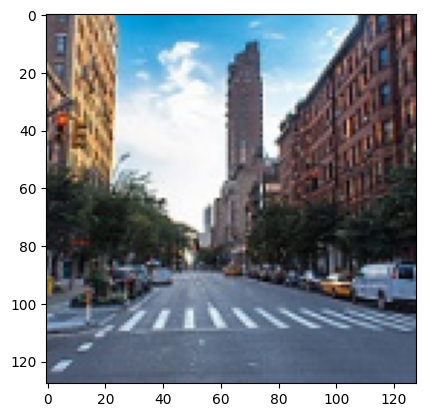

In [ ]:
my_img = X_train[13000]
plt.imshow(my_img)


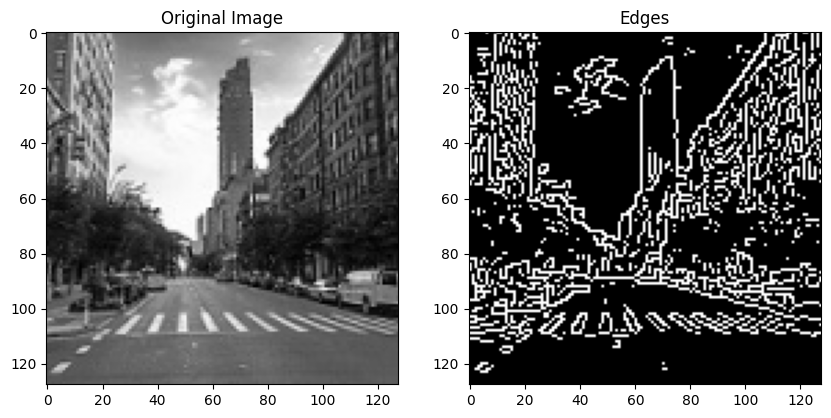

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.cvtColor(my_img, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detector
edges = cv2.Canny(image, 128, 128)

# Display the original image and the edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Edges')
plt.imshow(edges, cmap='gray')
plt.show()

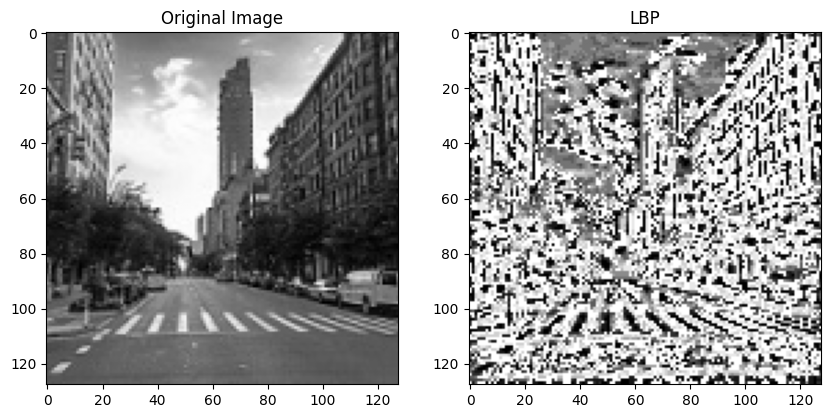

In [ ]:
from skimage import io, feature
import matplotlib.pyplot as plt


# Apply Local Binary Pattern (LBP)
lbp = feature.local_binary_pattern(image, P=10, R=3, method='uniform')

# Display the original image and the LBP result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('LBP')
plt.imshow(lbp, cmap='gray')
plt.show()

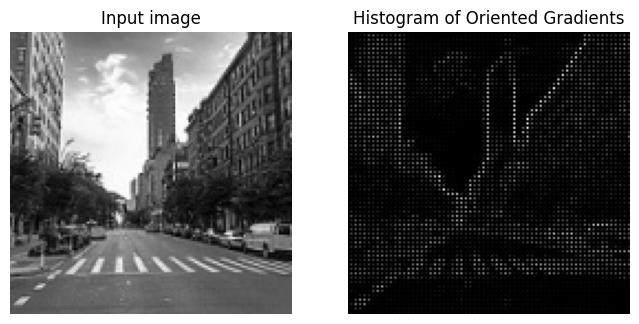

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

image = cv2.cvtColor(my_img, cv2.COLOR_RGB2GRAY)

fd, hog_image = hog(
    image,
    orientations=16,
    pixels_per_cell=(2, 2),
    cells_per_block=(8, 8),
    visualize=True,
    channel_axis=None,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image)

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm


def extract_features(batch):
    feats = []
    for img in tqdm(batch, desc="Extracting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        fd, _ = hog(
            gray,
            orientations=16,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None,
        )

        edges = cv2.Canny(gray, 128, 128).flatten().astype(np.float32) / 255.0

        lbp = local_binary_pattern(gray, P=10, R=3, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)

        feats.append(np.concatenate([fd, edges, lbp_hist]))
    return np.asarray(feats, dtype=np.float32)

X_train_feats = extract_features(X_train)
X_test_feats = extract_features(X_test)
y_train_feats = y_train.copy()
y_test_feats = y_test.copy()

Extracting features: 100%|██████████| 3000/3000 [01:48<00:00, 27.77it/s]


In [194]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Bruker ca 6 min

In [195]:


clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [ 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, verbose=1)


grid.fit(X_train_feats, y_train)
print("Best parameters found: ", grid.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
clf = grid.best_estimator_
clf.fit(X_train_feats, y_train)
y_pred = clf.predict(X_test_feats)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

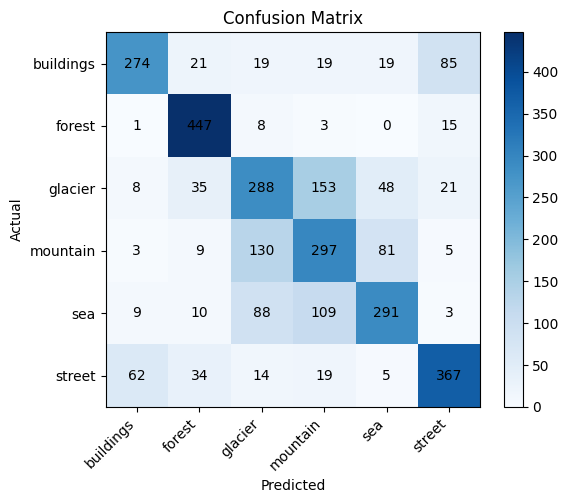

0.6546666666666666


In [192]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks(range(len(CLASS_NAMES)))
ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()
print(accuracy_score(y_test, y_pred))

In [193]:
print(accuracy_score(y_test, y_pred))

0.6546666666666666
